<a href="https://colab.research.google.com/github/LeonardoMiele/FruitGrowth/blob/main/Tomate_PBE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook presents a numerical solver for a system of two Partial Differential Equations (PDEs) representing the dynamics of cell populations under certain biological processes. The system is given by:

\begin{align}
\left\{
\begin{array}{l}
\frac{\partial n_P (t,x)}{\partial t} = \Omega[n(t,\cdot)]\left\{ -\frac{\partial }{\partial x} \left[\phi(x) n_P (t,x)\right] + 4 \gamma(2x) n_P (t,2x)
\ - \gamma(x) n_P (x) \right\} - \rho \, n_P (x), \\
\frac{\partial n_Q (t,x)}{\partial t} =  \Omega[n(t,\cdot)]\left\{-\frac{\partial }{\partial x} \left[\phi(x) n_Q (t,x)\right]\right\} + \rho n_P (t,x)
\end{array}
\right.
\end{align}
on a domain $x\in (0,L)$, with Dirichlet boundary conditions at $x=0$. Here, $n_P (t,x)$ and $n_Q (t,x)$ correspond to the densities at time $t$ of $P$ and $Q$ cells with size (mass) $x$, respectively.

**Main quantities**

The total population density: $n(t,x)=n_P (t,x)+n_Q (t,x)$

Total population:  $N(t)=\int_0^\infty n(t,x) dx$

Total mass:  $M(t)=\int_0^\infty x n(t,x) dx$

Total surface area, up to multiplication by the volumetric cell density: $S(t)=\int_0^\infty x^{2/3} n(t,x) dx$.

**Coefficients**

The size-dependent expansion function $\phi(x)$ describes the rate at which a cell of size $x$ increases its size and is chosen as:

\begin{equation}
    \phi(x)=r x^{\frac{2}{3}},
\end{equation}

The functional term $\Omega[n(t,\cdot)]$, influencing growth based on available resources, is defined by:

\begin{equation}
\Omega[n(t,\cdot)]=1-\frac{\int n(t,x)\,x^{\frac{2}{3}} dx}{K},
\end{equation}

where $K$ represents the effective carrying capacity for the total resource demand that the environment can support.

The division function $\gamma(x)$, describing the division rate of a cell of size $x$, is given by:

\begin{equation}
    \gamma(x)=\gamma_0 \frac{x^{12}}{h^{12}+x^{12}},
\end{equation}

with $\gamma_0=223.2$.

**Inputs**

The model has four parameters $\theta= \{r, \rho, K, h\}$ needing specification + the initial number of cells $N(0)$, the size $L$ of the domain and the final time $T$.

**Outputs**

The outputs are $n_P(t)$, $n_Q(t)$, $N(t)$, $M(t)$ at specified times and the spatial grid.

**Numerical method**

The numerical method uses an explicit Euler scheme in time (in order to deal with the nonlocal terms $S(t)$ and $n_P(t,2x)$).
It uses a non-uniform grid in space, with grid points more concentrated for small $x$ values
It deals separately with the transport and reaction terms, in two separate steps.
To deal with the transport equation, (1) we construct a spatial interpolation of the solution at time $t$ over $(0,L)$ (2) we compute the exact solution at time $t+dt$ based on the solution at time $t$.
To deal with the reaction term, we directly compute the terms in the right-hand side, and use an interpolation to compute the values at positions $2x$.


In [14]:
# required libraries
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import warnings

## Main solver

In [8]:
# @title

def solve_PBE_v1_plot(Theta, L, T, cell_num0, VT):
    # Define time step and spatial grid size
    dt = 0.01
    nxp = 4000

    # Create a non-uniform grid using hyperbolic tangent for better resolution at lower x values
    X = 1 + np.tanh(4 * (np.arange(-nxp // 2, nxp // 2 + 1) / nxp))
    X = X - X[0]  # Shift the grid so it starts from zero
    dx0 = 1e-5 / L  # Minimum grid spacing
    dx1 = 0.1 / L   # Maximum grid spacing
    Y = dx0 + X * (dx1 - dx0)  # Compute grid spacing
    R = np.cumsum(Y)  # Cumulative sum to get grid points
    xx = R / max(R) * L  # Normalize grid to domain length L
    xx = np.concatenate(([1e-6], xx))  # Ensure starting at a very small but not 0 x value (avoid division by 0)
    xs = np.diff(xx)  # Compute spacing between grid points

    # Extend grid for boundary conditions and interpolation close to the boundary
    xxneg = np.arange(-1, 0, 0.01)
    xxpos = np.arange(L + 0.5, 2 * L + 1, 0.5)

    # Time grid
    tt = np.arange(0, T + dt, dt)
    nx = len(xx)
    nt = len(tt)

    # Unpack parameters from Theta
    r, rho, K, h = Theta

    # Initial condition parameters
    x0 = 0.1
    K2 = 1e2
    kk = 223.2
    n = 12

    # Define growth, resource limitation, and division functions
    phi = lambda x: x ** (2 / 3)
    Omega = lambda M: r - M / K
    gamma = lambda x: kk * x ** n / (h ** n + x ** n)

    # Initial condition for cell densities
    ic = lambda x: cell_num0 * np.sqrt(K2) * np.exp(-K2 * (x - x0) ** 2) / np.sqrt(np.pi)
    nP = ic(xx)
    nP[round(3 * len(nP) / 4):] = 0  # Apply initial condition to part of the grid
    nQ = np.zeros_like(xx)  # Initialize nQ with zeros

    # Initialize arrays to store total populations, masses, and surface areas
    NPtot = np.zeros(nt)
    NQtot = np.zeros(nt)
    M = np.zeros(nt)
    S = np.zeros(nt)

    # Set initial values for total populations, masses, and surface areas
    NPtot[0] = np.sum((nP[:-1] + nP[1:]) / 2 * xs)
    NQtot[0] = np.sum((nQ[:-1] + nQ[1:]) / 2 * xs)
    M[0] = np.sum((nP[:-1] + nP[1:]) / 2 * (xx[:-1] + xx[1:]) / 2 * xs)
    S[0] = np.sum((nP[:-1] + nP[1:]) / 2 * (xx[:-1] ** (2 / 3) + xx[1:] ** (2 / 3)) / 2 * xs)

    # Initialize arrays for interpolated cell densities
    nnP = np.zeros((nx, len(VT)))
    nnQ = np.zeros((nx, len(VT)))
    j = 0

    # Main simulation loop
    for i, t in enumerate(tt[1:], 1):
        # Interpolate nP and nQ for boundary conditions and extrapolation
        fnP = interp1d(np.concatenate((xxneg, xx, xxpos)), np.concatenate((np.zeros_like(xxneg), nP, np.zeros_like(xxpos))), kind='linear', fill_value="extrapolate")
        fnQ = interp1d(np.concatenate((xxneg, xx, xxpos)), np.concatenate((np.zeros_like(xxneg), nQ, np.zeros_like(xxpos))), kind='linear', fill_value="extrapolate")

        # Define time change between t and t+dt for nP and nQ using interpolated functions
        fnPdt = lambda x: 1/9 * fnP(1/27 * (3 * x ** (1/3) - dt * Omega(S[i-1])) ** 3) * (3 * x ** (1/3) - dt * Omega(S[i-1])) ** 2 / x ** (2/3)
        fnQdt = lambda x: 1/9 * fnQ(1/27 * (3 * x ** (1/3) - dt * Omega(S[i-1])) ** 3) * (3 * x ** (1/3) - dt * Omega(S[i-1])) ** 2 / x ** (2/3)

        # Update nP and nQ
        nP = fnPdt(xx)
        nQ = fnQdt(xx)

        # Apply reactions to nQ and nP
        nQ += dt * rho * nP
        nP += dt * (-Omega(S[i-1]) * gamma(xx) * nP + 4 * Omega(S[i-1]) * gamma(2 * xx) * fnPdt(2 * xx) - rho * nP)
        nP[np.isnan(nP)] = 0  # Handle NaN values
        nQ[np.isnan(nQ)] = 0

        # Ensure non-negative densities
        nP[nP < 0] = 0
        nQ[nQ < 0] = 0

        # Update total populations, masses, and surface areas
        NPtot[i] = np.sum((nP[:-1] + nP[1:]) / 2 * xs)
        NQtot[i] = np.sum((nQ[:-1] + nQ[1:]) / 2 * xs)
        M[i] = np.sum((nP[:-1] + nP[1:] + nQ[:-1] + nQ[1:]) / 2 * (xx[:-1] + xx[1:]) / 2 * xs)
        S[i] = np.sum((nP[:-1] + nP[1:] + nQ[:-1] + nQ[1:]) / 2 * (xx[:-1] ** (2/3) + xx[1:] ** (2/3)) / 2 * xs)

        # Store densities at specified times
        if np.any(np.abs(t - VT) < dt / 2):
            nnP[:, j] = nP
            nnQ[:, j] = nQ
            j += 1
    N = NPtot + NQtot  # Compute total population
    M = M * 1e-6
    # Return spatial grid, cell densities, and total masses and populations
    return xx, tt, nnP, nnQ, M, N


## Data (cervil faible)

In [5]:
# @title
# Define the arrays
tobs = np.array([10, 10, 10, 12, 12, 12, 14, 14, 14, 15, 16, 17, 17, 20, 20, 20, 20, 23, 23, 23, 28, 28, 29, 32, 32, 32, 42, 43, 44, 48, 50, 50, 50, 51, 51])
Nobs = np.array([56204.6296296296, 95158.3333333333, 134446.666666667, 425687.037037037, 304546.666666667, 361414.814814815, 154401.851851852, 234668.518518519, 288411.111111111, 317763.888888889, 686379.629629630, 821333.333333333, 902111.111111111, 829074.074074074, 1195104.16666667, 1509062.50000000, 1636250.00000000, 1681979.16666667, 1530375.00000000, 1432366.07142857, 1724156.25000000, 1600000.00000000, 1610000, 1673812.50000000, 1508671.87500000, 1579166.66666667, 1409270.83333333, 1629739.58333333, 1350000.00000000, 1583750, 1543880.20833333, 1560572.91666667, 1413645.83333333, 1474114.58333333, 1517250])
Mobs = np.array([0.00480000000000000, 0.00420000000000000, 0.00680000000000000, 0.0356000000000000, 0.0151000000000000, 0.0292000000000000, 0.0249000000000000, 0.0272000000000000, 0.0610000000000000, 0.0700000000000000, 0.409000000000000, 0.351500000000000, 0.368700000000000, 0.968500000000000, 1.26000000000000, 0.875000000000000, 1.09000000000000, 1.86800000000000, 1.74100000000000, 2.14200000000000, 3.63300000000000, 3.99900000000000, 4.36100000000000, 4.32100000000000, 3.80270000000000, 4.16510000000000, 5.38600000000000, 5.27100000000000, 5.08800000000000, 6.52700000000000, 5.95600000000000, 5.22600000000000, 5.69300000000000, 5.65700000000000, 6.15600000000000])
edges = np.array([0, 1.98000000000000, 3.96000000000000, 5.94000000000000, 7.92000000000000, 9.90000000000000, 11.8800000000000, 13.8600000000000, 15.8400000000000, 17.8200000000000, 19.8000000000000, 21.7800000000000, 23.7600000000000, 25.7400000000000, 27.7200000000000, 29.7000000000000, 31.6800000000000, 33.6600000000000, 35.6400000000000, 37.6200000000000, 39.6000000000000, 41.5800000000000, 43.5600000000000, 45.5400000000000, 47.5200000000000, 49.5000000000000])
counts = np.array([0.227943148297131, 0.107267363904532, 0.0670421024403326, 0.0223473674801108, 0.0268168409761330, 0.00446947349602217, 0.0178778939840887, 0.00893894699204434, 0.00893894699204434, 0, 0.00446947349602217, 0.00446947349602218, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00446947349602216])


## Results

In [9]:
# Solve the problem with specified parameters

# Parameters
Thetapm = [0.3301, 0.6143, 9.8137e+06, 0.1044] # corresponding to posterior mode
L = 30
T = 51
cell_num0 = 3300
VT = np.arange(0.1, 51.1, 0.1)  # Time vector

# Solve the trajectory
xx, tt, nnP, nnQ, M, N = solve_PBE_v1_plot(Thetapm, L, T, cell_num0, VT)


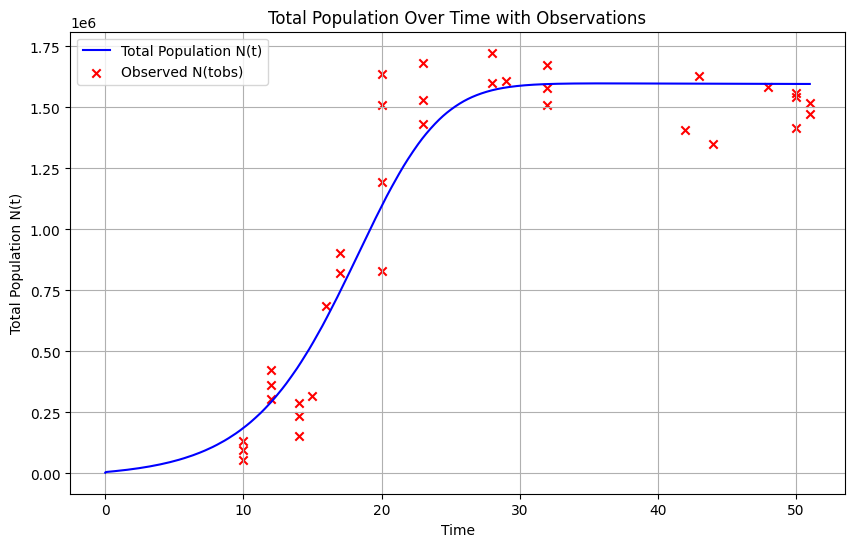

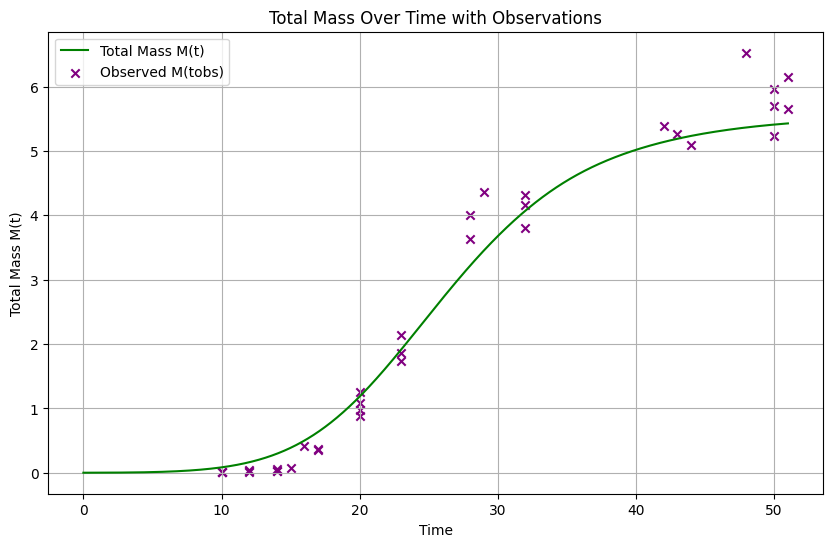

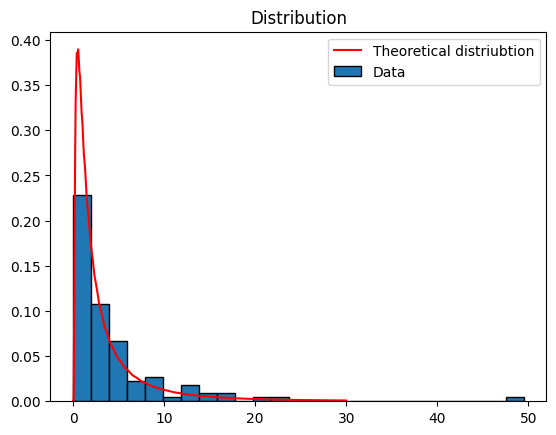

In [10]:
# Plot N(t) with superimposed data points
plt.figure(figsize=(10, 6))
plt.plot(tt, N, label='Total Population N(t)', color='blue')  # Plot N(t) vs. time
plt.scatter(tobs, Nobs, color='red', marker='x', label='Observed N(tobs)')  # Superimpose observed data
plt.xlabel('Time')
plt.ylabel('Total Population N(t)')
plt.title('Total Population Over Time with Observations')
plt.legend()
plt.grid(True)
plt.show()

# Plot M(t) with superimposed data points
plt.figure(figsize=(10, 6))
plt.plot(tt, M, label='Total Mass M(t)', color='green')  # Plot M(t) vs. time
plt.scatter(tobs, Mobs, color='purple', marker='x', label='Observed M(tobs)')  # Superimpose observed data
plt.xlabel('Time')
plt.ylabel('Total Mass M(t)')
plt.title('Total Mass Over Time with Observations')
plt.legend()
plt.grid(True)
plt.show()



# Plot histogram
plt.bar(edges[:-1], counts, width=np.diff(edges), edgecolor="black", align="edge", label='Data')

# Superimpose (nnP+nnQ)/N(end) plot
plt.plot(xx, (nnP[:,-1]+nnQ[:,-1])/N[-1], 'r', label='Theoretical distriubtion')

plt.title('Distribution')
plt.legend()
plt.show()

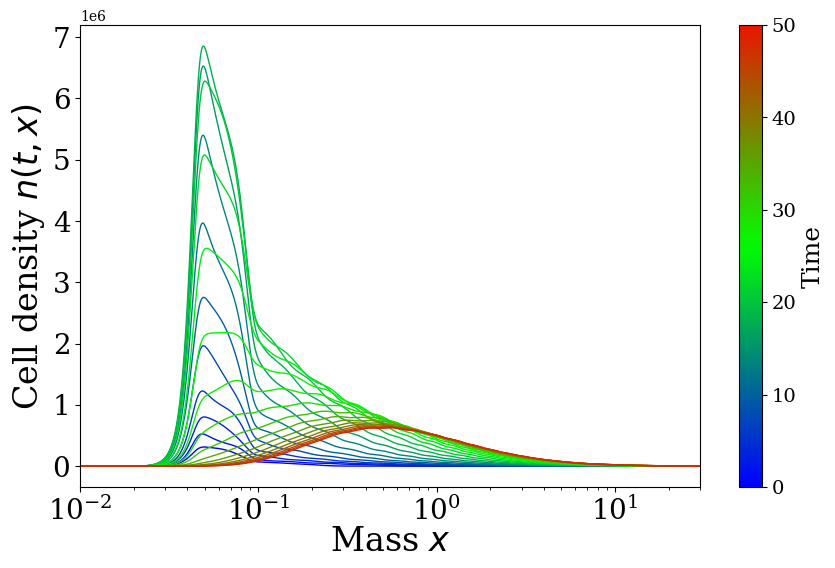

In [16]:
# plots the dynamics of cell density n(t,x)


# Set the 'Times New Roman' font globally
plt.rcParams["font.family"] = "serif"


Timesplot = np.arange(0, 52, 2)
dt = 0.005

# Find indices in VT satisfying the condition
indices = [np.argmin(np.abs(VT - time)) for time in Timesplot if np.abs(VT[np.argmin(np.abs(VT - time))] - time) < dt]
VT2 = VT[indices]

nnP2 = nnP[:, indices]
nnQ2 = nnQ[:, indices]

# Generate colormap
nc = len(nnP2[0])  # Number of colors
colors = np.zeros((nc, 3))  # Initialize color matrix

# Define the start (blue), middle (green), and end (red) colors in RGB
start_color = np.array([0, 0, 1])  # Blue
middle_color = np.array([0, 1, 0])  # Green
end_color = np.array([1, 0, 0])  # Red

# Generate colors for the transitions
for i in range(nc):
    if i < nc / 2:
        colors[i] = start_color + (middle_color - start_color) * (2 * i / nc)
    else:
        colors[i] = middle_color + (end_color - middle_color) * (2 * (i - nc / 2) / nc)

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Plotting
plt.figure(figsize=(10, 6))
norm = plt.Normalize(vmin=0, vmax=Timesplot.max())  # Adjust normalization to cover the range of Timesplot

for i in range(nc):  # Iterate over the range of nc instead of Timesplot
    # Calculate corresponding time for the legend or color mapping
    time = Timesplot[i] if i < len(Timesplot) else Timesplot[-1]  # Ensure we don't go out of bounds
    plt.semilogx(xx, nnP2[:, i] + nnQ2[:, i], color=cmap(norm(time)), linewidth=1)

plt.xlim([1e-2, 30])
plt.xlabel(r'Mass $x$', fontsize=24, labelpad=0)
plt.ylabel(r'Cell density $n(t,x)$', fontsize=24)
plt.gca().set_xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Create a ScalarMappable and initialize with the colormap and normalization
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable but it won't be used here

# Add the colorbar to the plot, adjusting it to display time properly
colorbar = plt.colorbar(sm, label='Time')
colorbar.set_label('Time', fontsize=18)  # Set font size for colorbar label
colorbar.ax.tick_params(labelsize=14)  # Set font size for colorbar labels

#from google.colab import drive
#drive.mount('/content/drive')

# Save the figure
#plt.savefig('cell_density_dynamics.png')

# Save the figure to Google Drive
#plt.savefig('/content/drive/My Drive/cell_density_dynamics.png')

warnings. filterwarnings("ignore")
plt.show()

